<h1>Corrective RAG (CRAG)</h1>

<h2>Setup</h2>

In [61]:
from dotenv import load_dotenv

load_dotenv()

True

In [62]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

llm = ChatOpenAI(model="gpt-4o", temperature=0)
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [54]:
# Test
response = llm.invoke("Hi")
response

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-df3f4453-2915-4ab1-ae40-c623843fad74-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

<h2>Retriever</h2>

In [63]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls] #Load documents
docs_list = [item for sublist in docs for item in sublist] #Flatten the list

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=250, chunk_overlap=0
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

In [64]:
# Test
question = "agent memory"
documents = retriever.invoke(question) #the default number of retrieved documents (k) is 4
doc_txt = documents[1].page_content

In [65]:
type(documents[0])

langchain_core.documents.base.Document

<h2>Grader</h2>

In [66]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(
        description="Documents are relevant to the question, 'yes' or 'no'"
    )

# LLM with function call
structured_llm_grader = llm.with_structured_output(GradeDocuments)

# Prompt
system = """You are a grader assessing relevance of a retrieved document to a user question. \n 
    If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant. \n
    Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""
grade_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "Retrieved document: \n\n {document} \n\n User question: {question}"),
    ]
)

retrieval_grader = grade_prompt | structured_llm_grader

In [67]:
# Test
question = "agent memory"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
print(retrieval_grader.invoke({"question": question, "document": doc_txt}))

binary_score='yes'


<h2>Generate Answer</h2>

In [68]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser

# Prompt
prompt = hub.pull("rlm/rag-prompt")

# Chain
rag_chain = prompt | llm | StrOutputParser()

In [69]:
# Test
generation = rag_chain.invoke({"context": docs, "question": question})
print(generation)

In an LLM-powered autonomous agent system, memory is divided into short-term and long-term components. Short-term memory involves in-context learning, while long-term memory allows the agent to retain and recall information over extended periods, often using an external vector store for fast retrieval. This memory system enables agents to learn from past experiences and improve future actions.


<h2>Question Re-writer</h2>

In [70]:
# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for web search. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)

question_rewriter = re_write_prompt | llm | StrOutputParser()

In [71]:
# Test
question_rewriter.invoke({"question": question})

'What is agent memory and how does it function in artificial intelligence systems?'

<h2>Web Search Tool</h2>

In [72]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(max_results=3)

In [87]:
# Test
docs = web_search_tool.invoke(question)
docs

[{'url': 'https://www.deeplearning.ai/short-courses/llms-as-operating-systems-agent-memory/',
  'content': 'LLMs as Operating Systems: Agent Memory - DeepLearning.AI Build agents with long-term, persistent memory using Letta to manage and edit context efficiently. Learn how an LLM agent can act as an operating system to manage memory, autonomously optimizing context use. Learn how to build agentic memory into your applications in this short course, LLMs as Operating Systems: Agent Memory, created in partnership with Letta, and taught by its founders Charles Packer and Sarah Wooders. Based on the innovative approach in the MemGPT research paper “Towards LLMs as Operating Systems,” its authors, two of whom are Charles and Sarah, proposed using an LLM agent to manage this context window, building a management system that provides applications with managed, persistent memory.'},
 {'url': 'https://docs.aws.amazon.com/bedrock/latest/userguide/agents-configure-memory.html',
  'content': 'Enab

<h2>Graph State</h2>

In [74]:
from typing import List

from typing_extensions import TypedDict

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        web_search: whether to add search
        documents: list of documents
    """
    question: str
    generation: str
    web_search: str
    documents: List[str]

<h2>Retriever Node</h2>

In [75]:
from langchain.schema import Document

def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Retrieval
    documents = retriever.invoke(question)
    return {"documents": documents, "question": question}

<h2>Grader Node</h2>

In [76]:
def grade(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]

    # Score each doc
    filtered_docs = []
    web_search = "No"
    for doc in documents:
        score = retrieval_grader.invoke(
            {"question": question, "document": doc.page_content}
        )
        grade = score.binary_score #if any docs are relevant, we can move to gene answer
        if grade == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(doc)
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            web_search = "Yes"
    return {"documents": filtered_docs, "question": question, "web_search": web_search}

<h2>Generate Node</h2>

In [77]:
def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"documents": documents, "question": question, "generation": generation}

<h2>Question Re-writer Node</h2>

In [78]:
def transform(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}

<h2>Web Search Node</h2>

In [88]:
def search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state["documents"]

    # Web search
    docs = web_search_tool.invoke(question)
    web_results = "\n".join([doc["content"] for doc in docs])
    documents.append(Document(page_content=web_results))

    return {"documents": documents, "question": question}

<h2>Conditional Edge</h2>

In [89]:
def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    web_search = state["web_search"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print(
            "---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---"
        )
        return "transform"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

<h2>Compile Graph</h2>

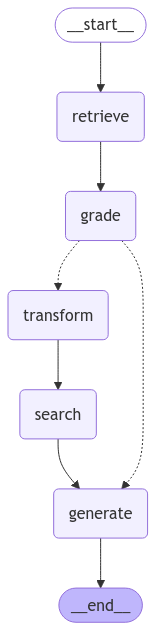

In [90]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade", grade)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("transform", transform)  # transform_query
workflow.add_node("search", search)  # web search

# Build graph
workflow.add_edge(START, "retrieve")
workflow.add_edge("retrieve", "grade")
workflow.add_conditional_edges(
    "grade",
    decide_to_generate,
    {
        "transform": "transform",
        "generate": "generate",
    },
)
workflow.add_edge("transform", "search")
workflow.add_edge("search", "generate")
workflow.add_edge("generate", END)

# Compile
graph = workflow.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [91]:
from pprint import pprint

inputs = {"question": "What are the types of agent memory?"}
for output in graph.stream(inputs):
    for key, value in output.items():
        # Node
        pprint(f"Node '{key}':")
        # Optional: print full state at each node
        # pprint.pprint(value["keys"], indent=2, width=80, depth=None)
    pprint("\n---\n")

# Final generation
pprint(value["generation"])

---RETRIEVE---
"Node 'retrieve':"
'\n---\n'
---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---
"Node 'grade':"
'\n---\n'
---TRANSFORM QUERY---
"Node 'transform':"
'\n---\n'
---WEB SEARCH---
"Node 'search':"
'\n---\n'
---GENERATE---
"Node 'generate':"
'\n---\n'
('Artificial intelligence agents use episodic, semantic, procedural, and '
 'short-term memory systems. These memory types help AI agents dynamically '
 'adapt, provide personalized interactions, and solve complex problems.')


In [98]:
for event in graph.stream({"question": "How does the AlphaCodium paper work?"}, stream_mode="values"):
    print(event.get('generation', ''))


---RETRIEVE---

---CHECK DOCUMENT RELEVANCE TO QUESTION---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---GRADE: DOCUMENT NOT RELEVANT---
---ASSESS GRADED DOCUMENTS---
---DECISION: ALL DOCUMENTS ARE NOT RELEVANT TO QUESTION, TRANSFORM QUERY---

---TRANSFORM QUERY---

---WEB SEARCH---

---GENERATE---
The AlphaCodium research paper introduces a new methodology for enhancing code generation by large language models (LLMs) through a test-based, multi-stage, iterative process. This approach significantly improves performance on complex code generation tasks, particularly in competitive programming, by using a specialized flow without additional training. The methodology was tested on the CodeContests dataset, demonstrating its effectiveness in improving LLM performance compared to direct prompt input methods.
